In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 1, 2, 3, 4, 5, 6]
clinical_df['status_strat'] = np.select(conditions, values)
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
clinical_df['stage_m_strat'] = clinical_df['ajcc_clinical_m']
clinical_df['stage_m_strat'] = clinical_df['ajcc_pathologic_m'].map({'M0' : 0, 'MX' : 1})
clinical_df['stage_n_strat'] = clinical_df['ajcc_clinical_n'].replace("'--", np.NaN).map({'NX' : 0, 'N0' : 1, 'N1' : 2, 'N2' : 3, 'N2a' : 3, 'N2b' : 3, 'N2c' : 3, 'N3' : 4})
clinical_df['stage_strat'] = clinical_df['ajcc_clinical_stage'].replace("'--", np.NaN).map({'Stage I' : 0, 'Stage II' : 1, 'Stage III' : 2, 'Stage IVA' : 3, 'Stage IVB' : 3, 'Stage IVC' : 3})
clinical_df['stage_t_strat'] = clinical_df['ajcc_clinical_t'].replace("'--", np.NaN).map({'TX' : 0, 'T0' : 1, 'T1' : 2, 'T2' : 3, 'T3' : 4, 'T4' : 5, 'T4a' : 5, 'T4b' : 5})
clinical_df['diag_strat'] = clinical_df['morphology'].replace("'--", np.NaN).map({'8070/3' : 0, '8071/3' : 1, '8072/3' : 2, '8074/3' : 3, '8083/3' : 4})

clinical_df = clinical_df[list(set(clinical_df.columns) & set(['case_id','vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']))]

file_to_case_df = pd.read_csv('file_to_case.tsv', sep='\t')

df_s1 = pd.read_csv('rnaseq_s1.tsv', sep='\t')
df_s2 = pd.read_csv('rnaseq_s2.tsv', sep='\t')
df_s1_s2 = pd.read_csv('rnaseq_s1_s2.tsv', sep='\t')

data_frames = [df_s1, df_s2, df_s1_s2]
data_frame_names = ['S1', 'S2', 'S1_S2']

In [7]:
#status_counts = clinical_df['status_strat'].value_counts().sort_index()
#print(status_counts)


# Classification

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Assuming clinical_df, file_to_case_df, df_s1, df_s2, and df_s1_s2 are already loaded and preprocessed

data_frames = [df_s1, df_s2, df_s1_s2]
data_frame_names = ['S1', 'S2', 'S1_S2']
targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_id'])

    for target in targets:
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        # Cross-validation scores
        print(f"{target} in {data_frame_names[df_index]} dataset")
        scores = cross_val_score(RandomForestClassifier(), X, y, cv=6, scoring='f1_micro')
        print("Cross-validation scores:", scores)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        classifier = RandomForestClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print("F1 score (micro):", f1_score(y_test, y_pred, average='micro'))


vital_status in S1 dataset
Cross-validation scores: [0.59574468 0.69148936 0.55319149 0.5        0.62765957 0.57446809]
F1 score (micro): 0.5263157894736842
status_strat in S1 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.57446809 0.58510638 0.54255319 0.57446809 0.5212766  0.55319149]
F1 score (micro): 0.5789473684210527
stage_m_strat in S1 dataset
Cross-validation scores: [0.79069767 0.66666667 0.73809524 0.73809524 0.73809524 0.76190476]
F1 score (micro): 0.8076923076923077
stage_n_strat in S1 dataset
Cross-validation scores: [0.54255319 0.53191489 0.47311828 0.55913978 0.50537634 0.53763441]
F1 score (micro): 0.48214285714285715
stage_strat in S1 dataset
Cross-validation scores: [0.51086957 0.54347826 0.54347826 0.52173913 0.58241758 0.54945055]
F1 score (micro): 0.5272727272727272
stage_t_strat in S1 dataset
Cross-validation scores: [0.37234043 0.35106383 0.33333333 0.33333333 0.44086022 0.34408602]
F1 score (micro): 0.39285714285714285
diag_strat in S1 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.86170213 0.86170213 0.86170213 0.86170213 0.85106383 0.85106383]
F1 score (micro): 0.8771929824561403
vital_status in S2 dataset
Cross-validation scores: [0.56382979 0.58510638 0.59574468 0.57446809 0.57446809 0.5       ]
F1 score (micro): 0.5789473684210527
status_strat in S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.54255319 0.54255319 0.5212766  0.5        0.5106383  0.45744681]
F1 score (micro): 0.5263157894736842
stage_m_strat in S2 dataset
Cross-validation scores: [0.74418605 0.73809524 0.73809524 0.69047619 0.73809524 0.76190476]
F1 score (micro): 0.8076923076923077
stage_n_strat in S2 dataset
Cross-validation scores: [0.4893617  0.4893617  0.49462366 0.53763441 0.48387097 0.52688172]
F1 score (micro): 0.5
stage_strat in S2 dataset
Cross-validation scores: [0.52173913 0.5326087  0.48913043 0.52173913 0.51648352 0.45054945]
F1 score (micro): 0.4909090909090909
stage_t_strat in S2 dataset
Cross-validation scores: [0.35106383 0.29787234 0.33333333 0.33333333 0.29032258 0.32258065]
F1 score (micro): 0.42857142857142855
diag_strat in S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.86170213 0.86170213 0.86170213 0.85106383 0.85106383 0.85106383]
F1 score (micro): 0.8771929824561403
vital_status in S1_S2 dataset
Cross-validation scores: [0.59574468 0.60638298 0.60638298 0.54255319 0.62765957 0.55319149]
F1 score (micro): 0.5964912280701754
status_strat in S1_S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.57446809 0.56382979 0.56382979 0.55319149 0.53191489 0.5212766 ]
F1 score (micro): 0.5614035087719298
stage_m_strat in S1_S2 dataset
Cross-validation scores: [0.74418605 0.71428571 0.76190476 0.71428571 0.73809524 0.73809524]
F1 score (micro): 0.8076923076923077
stage_n_strat in S1_S2 dataset
Cross-validation scores: [0.5212766  0.4787234  0.48387097 0.50537634 0.4516129  0.53763441]
F1 score (micro): 0.5357142857142857
stage_strat in S1_S2 dataset
Cross-validation scores: [0.51086957 0.51086957 0.51086957 0.51086957 0.54945055 0.53846154]
F1 score (micro): 0.5636363636363636
stage_t_strat in S1_S2 dataset
Cross-validation scores: [0.32978723 0.32978723 0.3655914  0.39784946 0.41935484 0.3655914 ]
F1 score (micro): 0.39285714285714285
diag_strat in S1_S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.86170213 0.86170213 0.86170213 0.86170213 0.85106383 0.85106383]
F1 score (micro): 0.8771929824561403


# Dimensionality Rediction

Visualization of Latent Spaces across Datasets and Targets

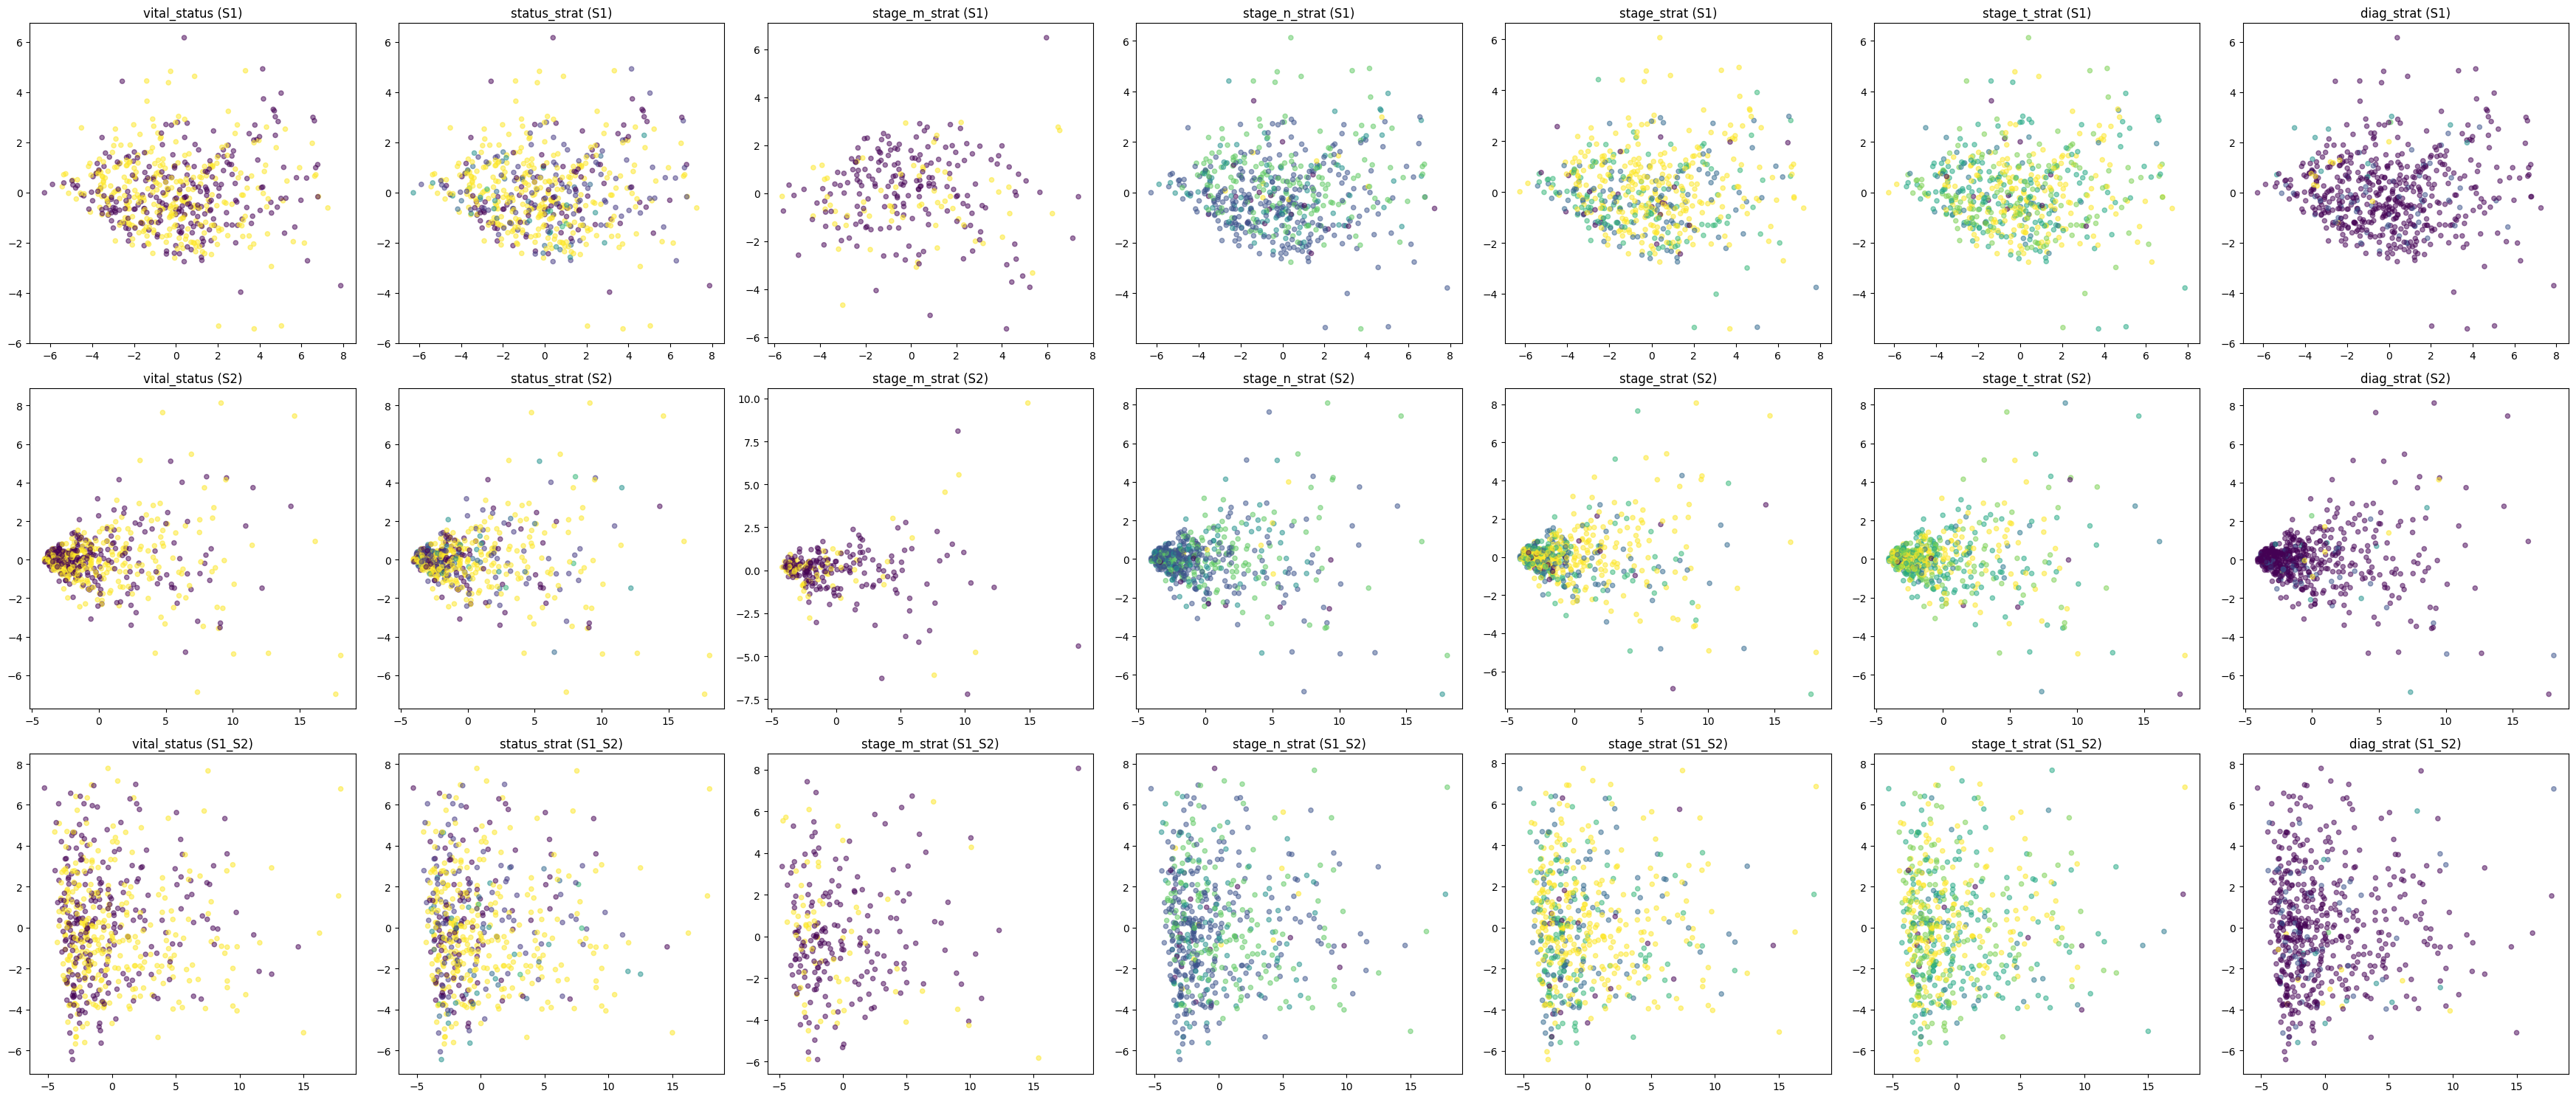

In [10]:
from sklearn.decomposition import PCA

targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

plt.figure(figsize=(35, 15))

for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_id'])

    for i, target in enumerate(targets):
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X_scaled)
        principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

        plt.subplot(3, 7, df_index * 7 + i + 1)
        plt.title(f"{target} ({data_frame_names[df_index]})")
        plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)

plt.tight_layout()
plt.show()

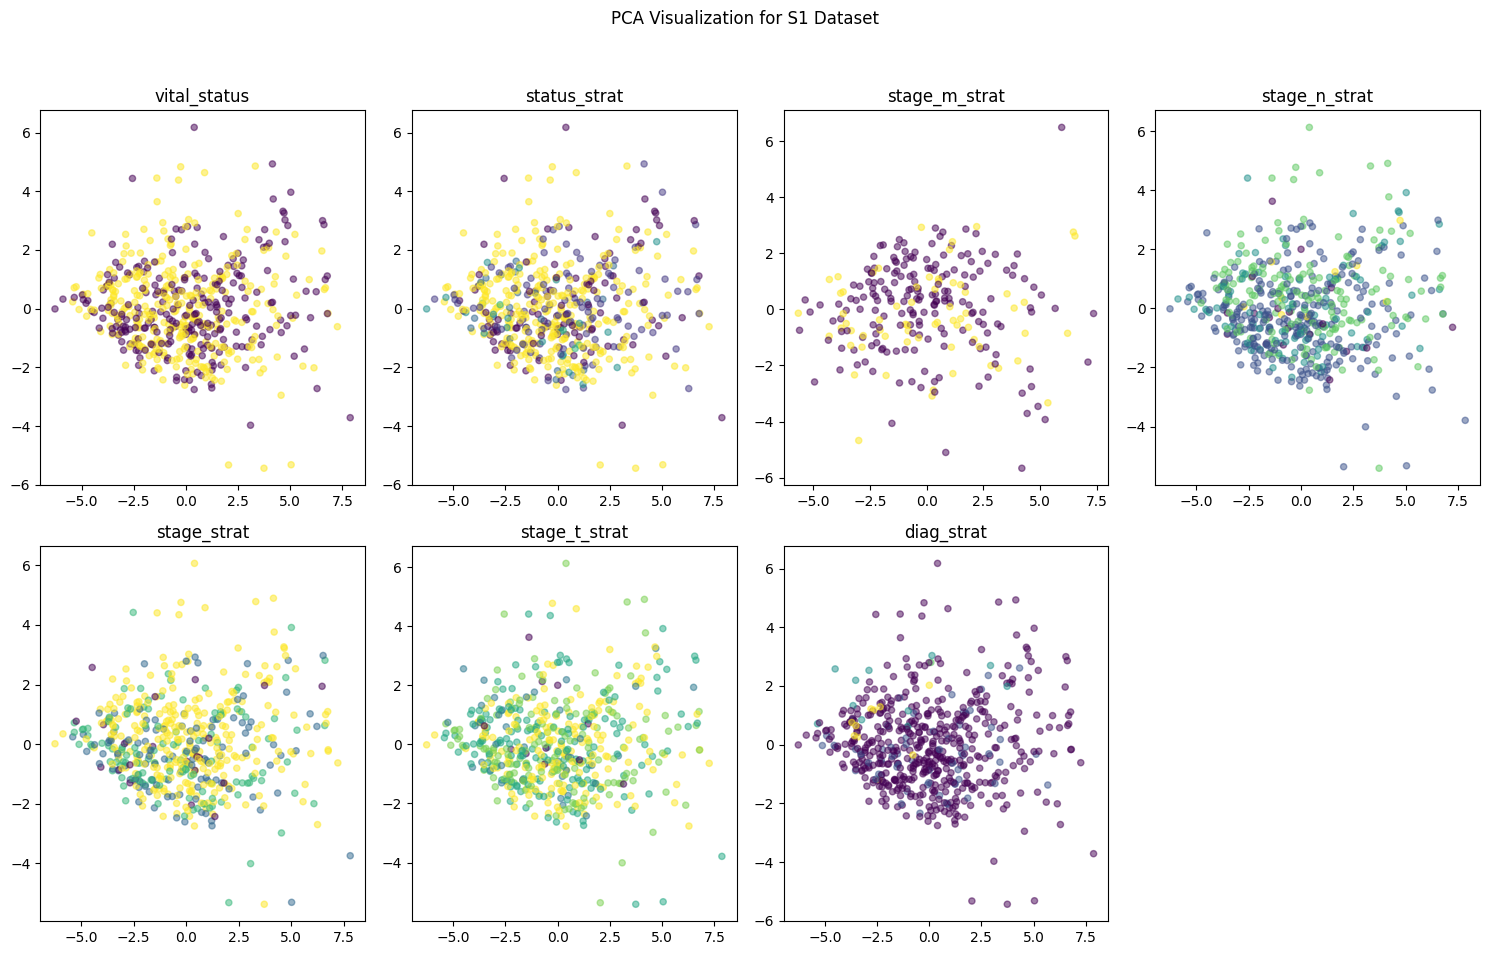

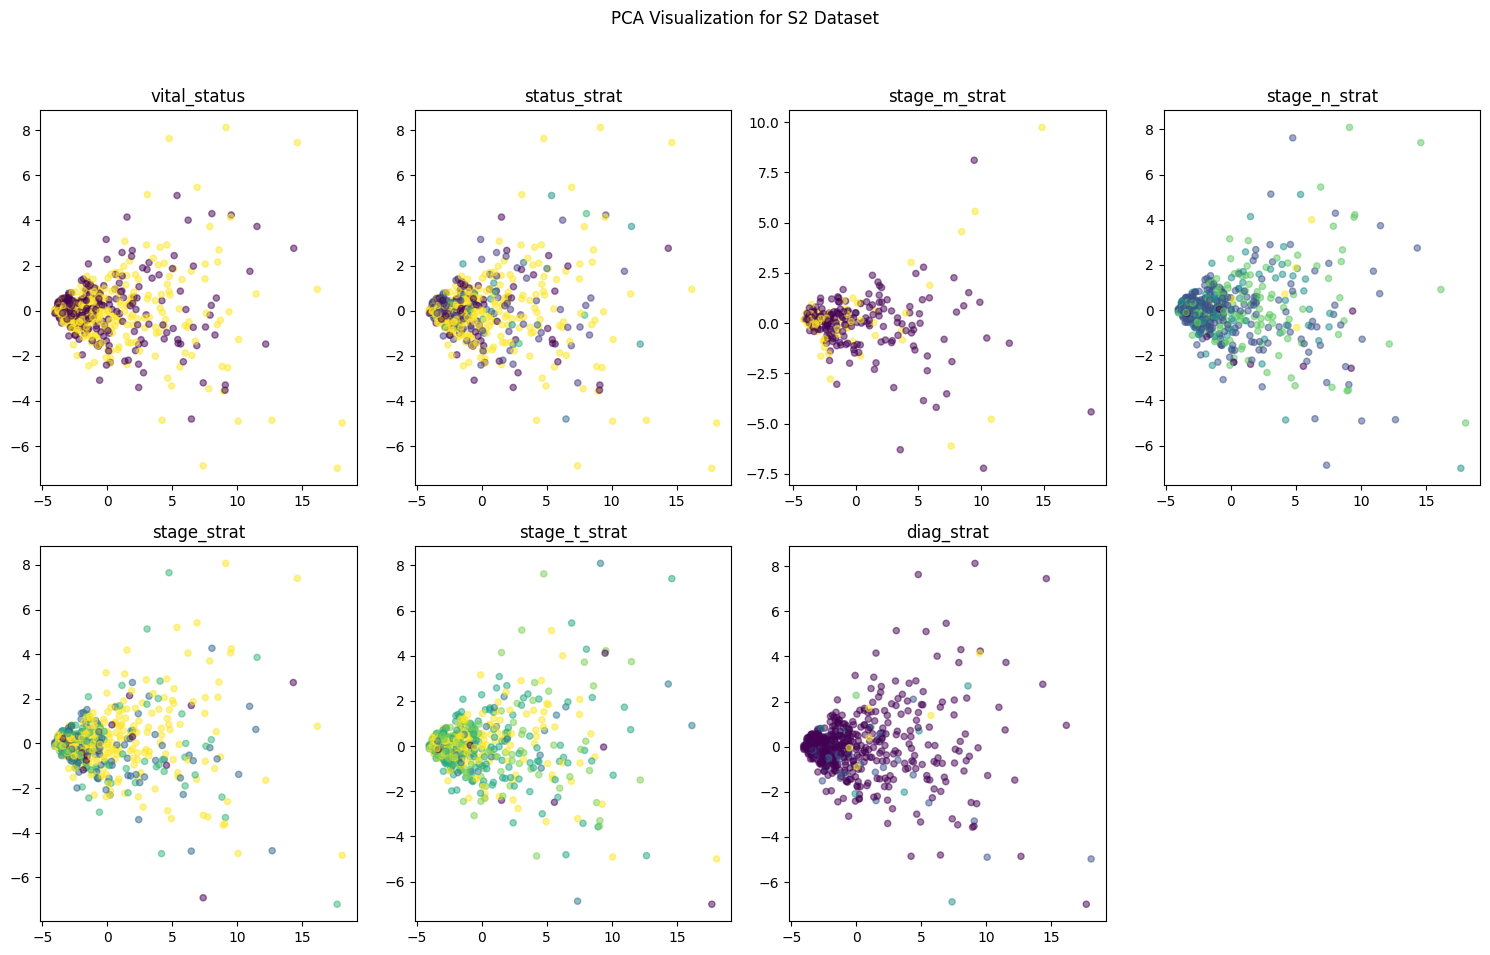

In [11]:
for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_id'])

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"PCA Visualization for {data_frame_names[df_index]} Dataset")

    for i, target in enumerate(targets):
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        
        X_scaled = StandardScaler().fit_transform(X)
        principal_components = PCA(n_components=2).fit_transform(X_scaled)
        principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
        
        plt.subplot(2, 4, i + 1) 
        plt.title(target)
        plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


# Autoencoder

In [17]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from keras.models import Model

targets = ['status_strat']

for df_index, df in enumerate(data_frames):
    plt.figure(figsize=(15, 10))
    
    for l in [20, 10, 5, 2, 1]:
        target = 'status_strat'
        df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
        df_merged = pd.merge(df_merged, clinical_df, on='case_id', how='left')
        df_final = df_merged.drop(columns=['file_id', 'case_id'])
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        input_img = Input(shape=(X.shape[1],))
        encoded = Dense(X.shape[1], activation='relu')(input_img)
        encoded = Dense(l, activation='relu')(encoded) 
        decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)

        plt.plot(history.history['loss'], label=str(l) + ' neurons: train')
        plt.plot(history.history['val_loss'], label=str(l) + ' neurons: val')
    
    plt.title(f'Model loss over epochs for {data_frame_names[df_index]} dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()


In [20]:
targets = ['status_strat']

for df_index, df in enumerate(data_frames):
    plt.figure(figsize=(15, 10))
    
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_id'])
    
    for l in [20, 10, 5, 2, 1]:
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[targets[0]]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)
        
        input_img = Input(shape=(X.shape[1],))
        encoded = Dense(l, activation='relu')(input_img)
        decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)
        
        encoder = Model(input_img, encoded)
        encoded_imgs = encoder.predict(X)
        
        X_encoded_scaled = MinMaxScaler().fit_transform(encoded_imgs)
        
        X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.1, random_state=42)
        
        classifier = RandomForestClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        print(f"Data set: {data_frame_names[df_index]}, Neurons in compressed layer: {l}, F1 Score (micro): {f1_score(y_test, y_pred, average='micro')}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 20, F1 Score (micro): 0.49122807017543857
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 10, F1 Score (micro): 0.543859649122807
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 5, F1 Score (micro): 0.5263157894736842
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 2, F1 Score (micro): 0.5263157894736842
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 1, F1 Score (micro): 0.43859649122807015
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 20, F1 Score (micro): 0.5614035087719298
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 10, F1 Score (micro): 0.47368421052631576
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 5, F1 Score (micro): 0.543859649122807
18/18 ━━━━━

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

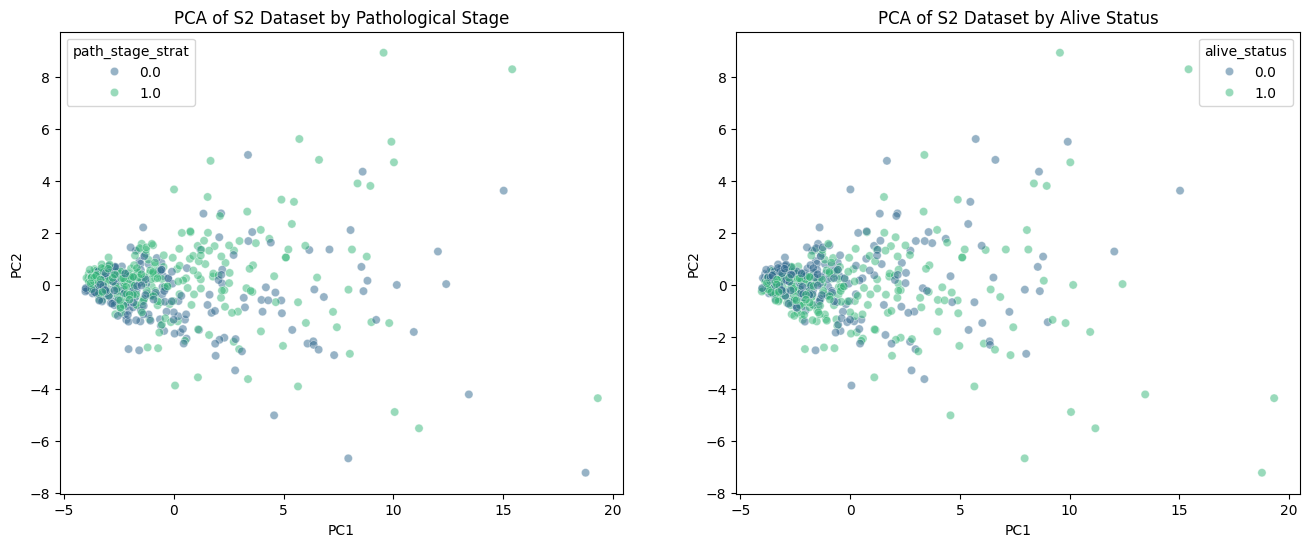

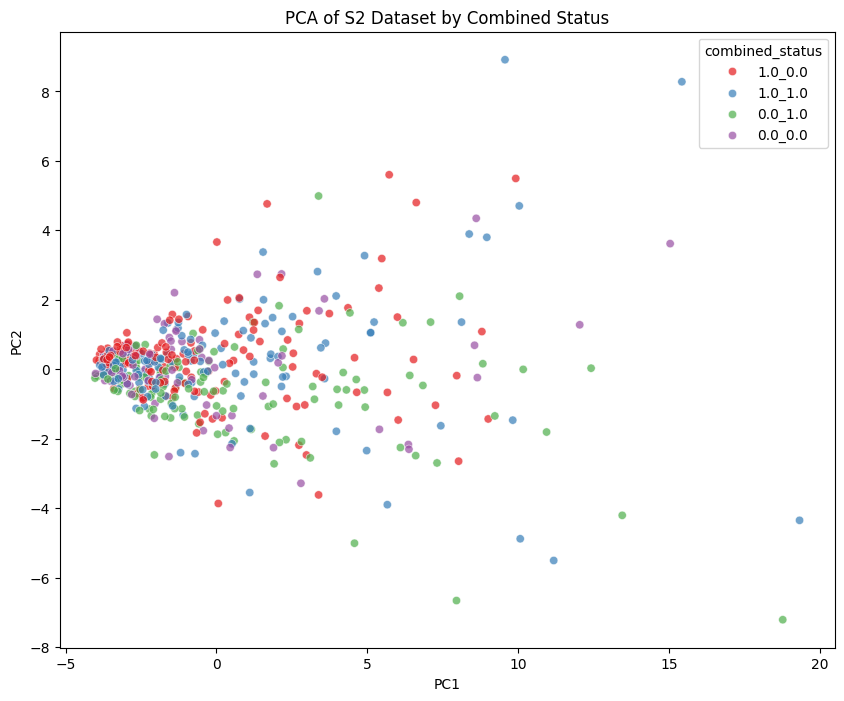

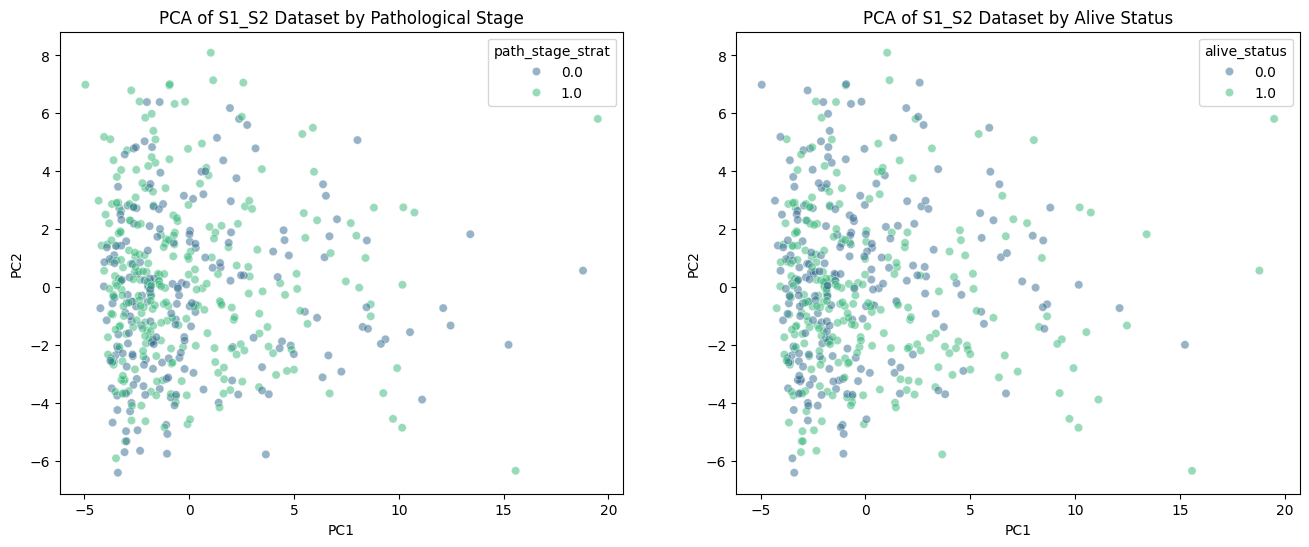

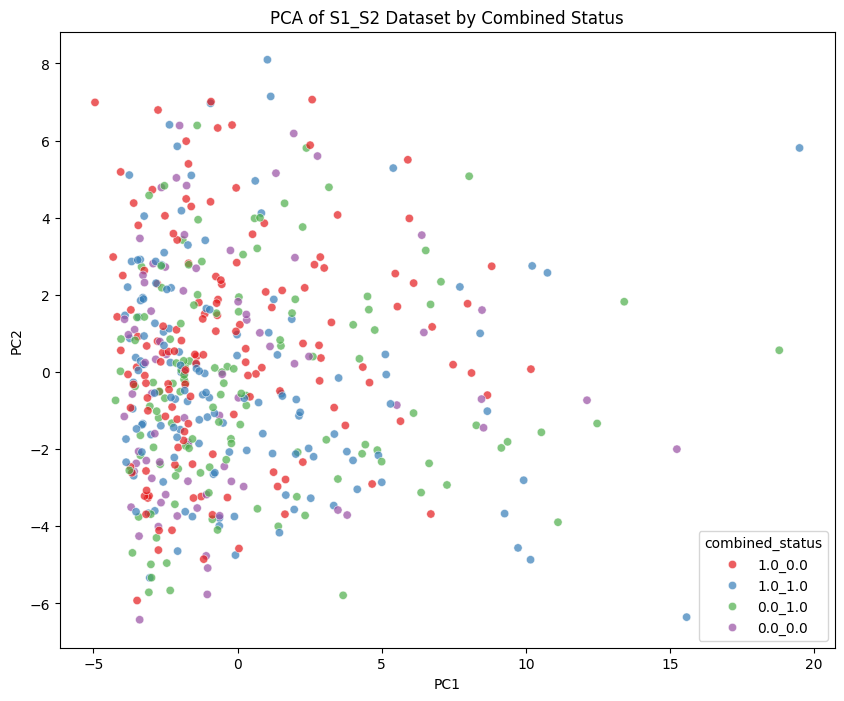

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I': 0, 'Stage II': 0, 'Stage III': 0, 'Stage IVA': 1, 'Stage IVB': 1, 'Stage IVC': 1})
clinical_df['alive_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
clinical_df = clinical_df[['case_id', 'path_stage_strat', 'alive_status']]

file_to_case_df = pd.read_csv('file_to_case.tsv', sep='\t')
data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for data_file, name in zip(data_files, data_frame_names):
    df = pd.read_csv(data_file, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()
    
    df['combined_status'] = df['path_stage_strat'].astype(str) + "_" + df['alive_status'].astype(str)
    
    X = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[['path_stage_strat', 'alive_status', 'combined_status']].reset_index(drop=True)], axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(ax=axs[0], x='PC1', y='PC2', hue='path_stage_strat', data=finalDf, palette='viridis', alpha=0.5)
    axs[0].set_title(f'PCA of {name} Dataset by Pathological Stage')
    
    sns.scatterplot(ax=axs[1], x='PC1', y='PC2', hue='alive_status', data=finalDf, palette='viridis', alpha=0.5)
    axs[1].set_title(f'PCA of {name} Dataset by Alive Status')
    
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='combined_status', data=finalDf, palette='Set1', alpha=0.7)
    plt.title(f'PCA of {name} Dataset by Combined Status')
    plt.show()


In [79]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Results for dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = MinMaxScaler().fit_transform(df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status']))
    y = df['path_stage_strat'].values 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    print(f"Accuracy for {dataset_name}: {accuracy:.4f}\n")


Results for dataset S1:
Accuracy for S1: 0.5000

Results for dataset S2:
Accuracy for S2: 0.5102

Results for dataset S1_S2:
Accuracy for S1_S2: 0.5612



In [91]:
from keras.models import Model
from keras.layers import Input, Dense

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    y = df['path_stage_strat'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    input_img = Input(shape=(X_train_scaled.shape[1],))
    encoded = Dense(20, activation='relu')(input_img)
    encoded = Dense(10, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(20, activation='relu')(decoded)
    decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_train_encoded = encoder.predict(X_train_scaled)
    X_test_encoded = encoder.predict(X_test_scaled)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train_encoded, y_train)

    y_pred = classifier.predict(X_test_encoded)
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_name}: {overall_accuracy:.4f}\n")

Processing dataset S1:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy for S1: 0.5102

Processing dataset S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy for S2: 0.6224

Processing dataset S1_S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy for S1_S2: 0.5510



In [98]:
for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    df_alive = df[df['alive_status'] == 1]
    df_deceased = df[df['alive_status'] == 0]

    for df_sub, status in zip([df_alive, df_deceased], ['Alive', 'Deceased']):
        X = df_sub.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
        y = df_sub['path_stage_strat'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        input_img = Input(shape=(X_train_scaled.shape[1],))
        encoded = Dense(20, activation='relu')(input_img)
        encoded = Dense(10, activation='relu')(encoded)
        encoded = Dense(5, activation='relu')(encoded)
        decoded = Dense(10, activation='relu')(encoded)
        decoded = Dense(20, activation='relu')(decoded)
        decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

        X_train_encoded = encoder.predict(X_train_scaled)
        X_test_encoded = encoder.predict(X_test_scaled)

        classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        classifier.fit(X_train_encoded, y_train)

        y_pred = classifier.predict(X_test_encoded)
        overall_accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {dataset_name} - {status}: {overall_accuracy:.4f}\n")

Processing dataset S1:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy for S1 - Alive: 0.6111

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S1 - Deceased: 0.5333

Processing dataset S2:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S2 - Alive: 0.5926

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S2 - Deceased: 0.5556

Processing dataset S1_S2:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy for S1_S2 - Alive: 0.6481

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S1_S2 - Deceased: 0.6000



In [111]:
for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    y_alive_status = df['alive_status'].values
    y_final = df['path_stage_strat'].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    alive_classifier = RandomForestClassifier(random_state=42)
    alive_classifier.fit(X_scaled, y_alive_status)
    X_alive_status_proba = alive_classifier.predict_proba(X_scaled)

    X_final = np.hstack((X_scaled, X_alive_status_proba))

    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

    input_img = Input(shape=(X_train_final.shape[1],))
    encoded = Dense(20, activation='relu')(input_img)
    encoded = Dense(10, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(20, activation='relu')(decoded)
    decoded = Dense(X_train_final.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train_final, X_train_final, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_train_encoded = encoder.predict(X_train_final)
    X_test_encoded = encoder.predict(X_test_final)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    classifier.fit(X_train_encoded, y_train_final)

    y_pred = classifier.predict(X_test_encoded)
    overall_accuracy = accuracy_score(y_test_final, y_pred)
    print(f"Accuracy for {dataset_name}: {overall_accuracy:.4f}\n")


Processing dataset S1:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy for S1: 0.5306

Processing dataset S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy for S2: 0.5816

Processing dataset S1_S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Accuracy for S1_S2: 0.5816

